In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def mavg_strat(ts, short_mavg, long_mavg, tc):
    
    '''
    
    ret_ts: returns time series
    short_mavg: short moving avg parameter
    long_mavg: long moving avg parameter
    tc: transaction costs in decimal e.g. 1 = 100%, 0.5=50%
    
    '''
    df = ts.to_frame('ret')
    df['cum_ret'] = (df['ret']+1).cumprod() -1
    df['short_mavg_ret'] = df['cum_ret'].rolling(short_mavg).mean()
    df['long_mavg_ret'] = df['cum_ret'].rolling(long_mavg).mean()
    
    df = df[~df.long_mavg_ret.isna()]
    
    df.loc[:,"crossed"] = 0
    df.loc[df.short_mavg_ret>df.long_mavg_ret, "crossed"] = 1

    df['signal'] = df.crossed.diff()

    df['tc'] = df['signal'].abs() * tc 
    df['tc_cum'] = df['tc'].add(1).cumprod() -1
    
    df['num_trans'] = df['signal'].abs().sum()

    df['strat_ret_no_tc'] = df['ret']*df['crossed'] 
    df['cum_strat_ret_no_tc'] = df['strat_ret_no_tc'].add(1).cumprod() - 1

    df['cum_bmk_ret'] = df['ret'].add(1).cumprod() - 1
    
    df['strat_ret'] = df['ret']*df['crossed'] - df['tc']
    df['cum_strat_ret'] = df['strat_ret'].add(1).cumprod() - 1
    
    
    df['active_ret'] = df['cum_strat_ret'] - df['cum_ret']
    
    return df

## Loading data

In [8]:
df = pd.read_csv("./data/XBTUSD_DAILY.csv")

## From prices to daily returns and cumulative returns

In [9]:
df['ret'] = df['close']/df['close'].shift(1) -1
df['cum_ret'] = (df['ret']+1).cumprod() 

In [10]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [11]:
df

,open,high,low,close,volume,date_unix,ret,cum_ret
date,,,,,,,,
2013-10-06,122.00000,122.00000,122.00,122.00,0.100000,1381017600,NaN,NaN
2013-10-07,123.61000,123.61000,123.61,123.61,0.100000,1381104000,0.013197,1.013197
2013-10-08,123.91000,124.19000,123.90,124.18,3.991600,1381190400,0.004611,1.017869
2013-10-09,124.01687,124.01687,123.84,123.84,2.823000,1381276800,-0.002738,1.015082
2013-10-10,125.85000,125.86000,125.85,125.86,2.000000,1381363200,0.016311,1.031639
...,...,...,...,...,...,...,...,...
2021-12-08,50650.10000,51202.50000,48579.30,50515.10,2997.496479,1638921600,-0.002665,414.058197
2021-12-09,50525.10000,50819.50000,47298.40,47581.60,2691.499811,1639008000,-0.058072,390.013115
2021-12-10,47576.40000,50114.20000,46888.80,47218.30,3323.541756,1639094400,-0.007635,387.035246


# Cross validation

**Main concern**

- We need to correctly estimate the transaction costs. How much exactly do we pay everytime we enter/exit the long position?


**Objective function:**

- I want to maximise returns given mavg parameters (lambda1, lambda2)

**Starting with brute-force approach:**

- Looping over differnet values of lambda
- Calculate compunded returns as metric
- Find combinations that give me maximum returns

**Improvements:**

- Need to find a better way to backtest this strateg.
- Cross validating over different periods
- Get an average of the parameters

In [24]:
ret_ts = df['ret'].copy()

In [25]:
X_train = ret_ts.loc[:'2019-01-01'].copy()


In [26]:
s_avg = np.arange(1, 30)
l_avg = np.arange(2,60)

In [23]:
res_list=[]
for s in s_avg:
    for l in l_avg:
        if s<l:
            
            y_train = mavg_strat(X_train, short_mavg=s, long_mavg=l, tc=0.03)
            
            strat_ret = y_train.iloc[-1]['cum_strat_ret']
            num_trans = y_train['signal'].abs().sum()
            
            res_tmp = pd.DataFrame({'s_avg': [s], 'l_avg':l, 'strat_ret':strat_ret, 'num_trans': num_trans})
            res_list.append(res_tmp)
            

res = pd.concat(res_list)            

NameError: name 'cum_strat_ret' is not defined

In [27]:
res.sort_values('strat_ret').tail(20)

,s_avg,l_avg,strat_ret,num_trans
0,1,16,342.132335,224.0
0,1,12,401.016357,283.0
0,1,20,430.957172,182.0
0,1,26,459.890668,150.0
0,1,4,461.726682,578.0
0,1,14,462.005996,249.0
0,1,15,503.367840,227.0
0,1,5,520.773600,482.0
0,1,21,558.905556,160.0
0,1,11,573.377099,297.0


In [29]:
res.sort_values('strat_ret').tail(10)['l_avg'].mean()

14.7

## Using optimized parametes 

- Testing out-of-sample
- Short avg = 1d
- Long avg = 8d

In [30]:
X_test =  ret_ts.loc['2019-01-01':].copy()

y_test = mavg_strat(X_test, short_mavg=1, long_mavg=14, tc=0.03)

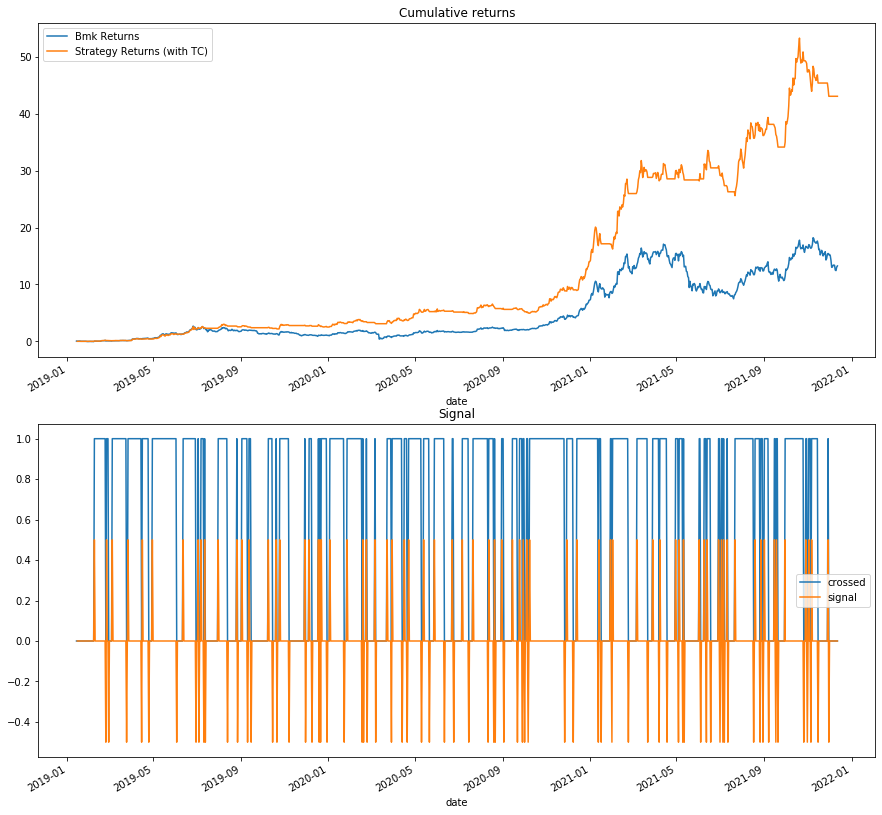

In [31]:
f,ax = plt.subplots(2,1,figsize=(15,15))

y_test['cum_bmk_ret'].plot(ax=ax[0], label='Bmk Returns')
y_test['cum_strat_ret'].plot(ax=ax[0], label='Strategy Returns (with TC)')
# y_test['cum_strat_ret_no_tc'].plot(ax=ax[0], label='Strategy Returns (no TC)')


y_test['crossed'].plot(ax=ax[1], label='crossed')
(y_test['signal']/2).plot(ax=ax[1], label='signal')

ax[0].legend()
ax[0].set_title("Cumulative returns")

ax[1].set_title("Signal")
ax[1].legend()

## £1 -> (1+100)*£1 = £101

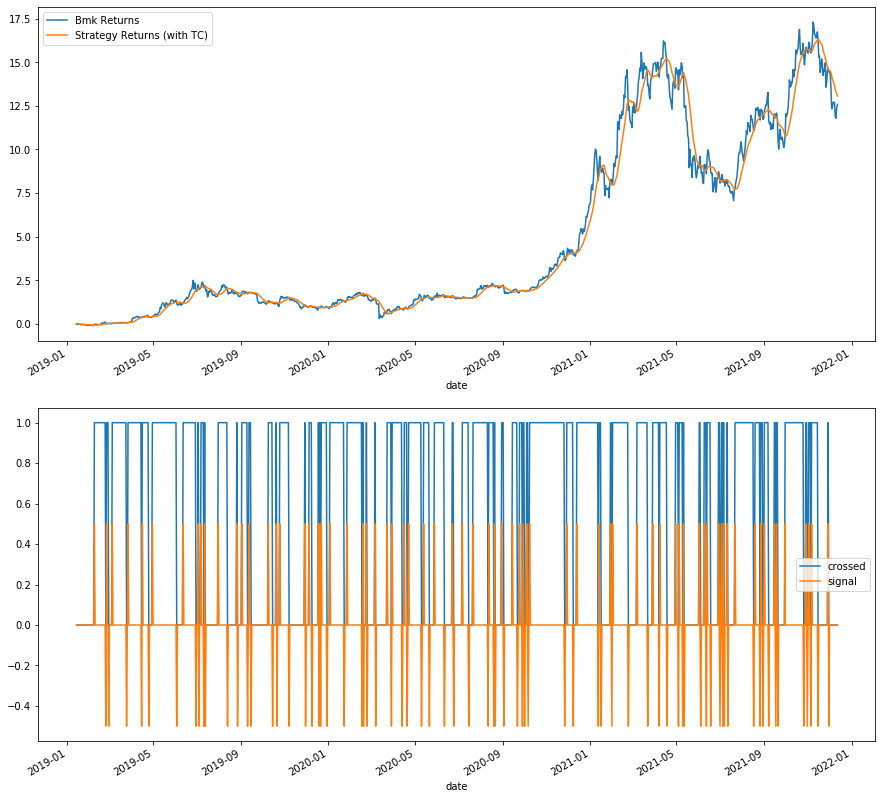

In [32]:
f,ax = plt.subplots(2,1,figsize=(15,15))

y_test['short_mavg_ret'].plot(ax=ax[0], label='Bmk Returns')
y_test['long_mavg_ret'].plot(ax=ax[0], label='Strategy Returns (with TC)')

y_test['crossed'].plot(ax=ax[1], label='crossed')
(y_test['signal']/2).plot(ax=ax[1], label='signal')

ax[0].legend()
ax[1].legend()

In [ ]:
110*2.5

In [ ]:
y_test['tc_cum'].plot()